In [1]:
from madmex.overlay.extractions import zonal_stats_xarray
import numpy as np
import datacube
%matplotlib inline
import matplotlib
from datacube.api import GridWorkflow
from madmex.wrappers import gwf_query
import fiona
import pprint
from madmex.io.vector_db import VectorDb, load_segmentation_from_dataset
from django.contrib.gis.geos import Polygon
from madmex.models import PredictObject
from madmex.modeling import BaseModel
from madmex.models import Model, PredictClassification
from django.contrib.gis.geos import Polygon
from madmex.util import chunk

In [2]:
#Next product was used to fit model
name_of_product = 's2_20m_fiona_test_2_2018'
resolution = (-10,10)
tilesize = (50020,50020)
origin = (2426720, 977160)
proj4 = '+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +a=6378137 +b=6378136.027241431 +units=m +no_defs'


In [3]:
gwf_kwargs = {'region': 'Jalisco', 'begin': '2018-01-01', 'end':'2018-12-31',
              'product': name_of_product,'resolution': resolution, 'origin': origin,
              'proj4': proj4, 'tilesize': tilesize}

In [4]:
iterable = gwf_query(**gwf_kwargs)

In [5]:
lista_iter = list(iterable)

In [6]:
[lista_iter[x][0] for x in range(0,len(lista_iter))]

[(28, -27),
 (28, -28),
 (30, -29),
 (30, -30),
 (28, -29),
 (28, -30),
 (29, -30),
 (30, -27),
 (29, -29),
 (30, -28),
 (29, -28),
 (29, -27)]

In [7]:
var = lista_iter[8]

In [8]:
sr_0 = GridWorkflow.load(var[1],dask_chunks={'x': 2000, 'y': 2000, 'time': 1})
sr_0

<xarray.Dataset>
Dimensions:     (time: 1, x: 5002, y: 5002)
Coordinates:
  * time        (time) datetime64[ns] 2018-07-02
  * y           (y) float64 1.026e+06 1.026e+06 ... 9.762e+05 9.761e+05
  * x           (x) float64 2.428e+06 2.428e+06 ... 2.478e+06 2.478e+06
Data variables:
    blue_mean   (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    green_mean  (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    red_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    re1_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    re2_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    re3_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    nir_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    swir1_mean  (time, y, x) int16 dask.array

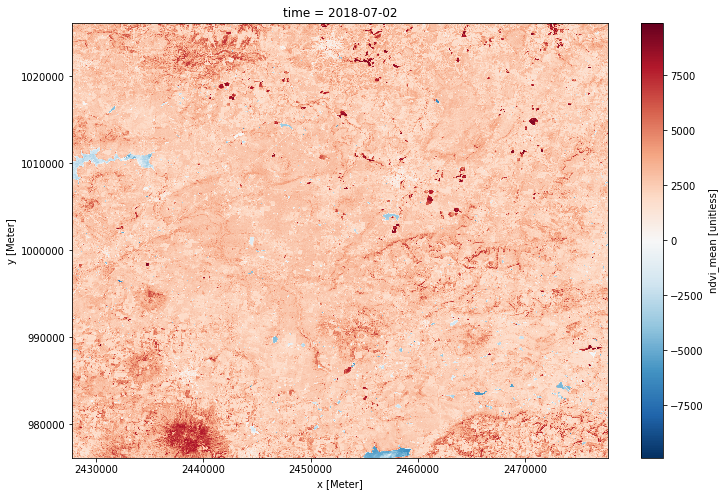

In [9]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
sr_0.ndvi_mean.plot()

In [9]:
segmentation_name = 's2_10m_some_scenes_fiona_test'

In [10]:
path = load_segmentation_from_dataset(sr_0, segmentation_name)

In [11]:
path

's3://segmentation-antares3-results/dc2f9b_sentinel2_29_-29_2018.shp'

In [12]:
name_model = 's2_fiona_test_model' + '_%d_%d' %(var[0][0],var[0][1])

In [13]:
name_model

's2_fiona_test_model_29_-29'

In [14]:
#get seg_id
poly = Polygon.from_ewkt(sr_0.geobox.extent.wkt) 
query_set = PredictObject.objects.filter(the_geom__intersects=poly,
                                     segmentation_information__name=segmentation_name)
seg_id = query_set[0].id

In [15]:
seg_id

1

In [20]:
name='s2_fiona_predict'

In [23]:
model_id

1

In [26]:
def predict_object_builder(i, pred, conf):
    return PredictClassification(model_id=model_id, predict_object_id=i,
                                 tag_id=pred, confidence=conf, name=name, segmentation=seg_id)

In [27]:
with fiona.open(path) as src:
    X_pred, y = zonal_stats_xarray(sr_0, src, 'id')
    PredModel = BaseModel.from_db(name_model)
    model_id = Model.objects.get(name=name_model).id
    y_pred = PredModel.predict(X_pred)
    y_conf = PredModel.predict_confidence(X_pred)
    for sub_zip in chunk(zip(y, y_pred, y_conf), 10000):
        obj_list = [predict_object_builder(i,pred,conf) for i, pred, conf in
                    sub_zip]
        PredictClassification.objects.bulk_create(obj_list)
        obj_list = None
    

ValueError: Cannot assign "1": "PredictClassification.segmentation" must be a "PredictObject" instance.

In [23]:
X_pred

array([[ 4.72582853e+02,  6.54138793e+02,  8.40590542e+02, ...,
         1.62831603e+03,  4.97898006e+00,  1.76500183e+02],
       [ 4.53378039e+02,  6.39167451e+02,  8.23304706e+02, ...,
         1.64829804e+03,  1.08034515e+01,  2.78774841e+02],
       [ 5.18131373e+02,  7.28714510e+02,  9.73007451e+02, ...,
         1.66631255e+03,  9.25008011e+00,  1.99561813e+02],
       ...,
       [ 4.50549119e+02,  7.23715460e+02,  1.00260117e+03, ...,
         2.19814638e+03,  2.77769876e+00,  1.37038849e+02],
       [ 5.20480245e+02,  9.15958189e+02,  8.01500575e+02, ...,
         2.00508746e+03,  1.41661182e-01, -9.03293262e+03],
       [ 3.93991012e+02,  6.25972255e+02,  8.68356780e+02, ...,
         2.14075694e+03,  2.93682218e+00,  1.93665863e+02]])

In [ ]:
y_pred

In [ ]:
y_conf

In [ ]:
#next lines just to retrieve information

In [24]:
#load model

In [25]:
name_model = 's2_fiona_test_model' + '_%d_%d' %(var[0][0],var[0][1])

In [26]:
name_model

's2_fiona_test_model_29_-29'

In [27]:
PredModel = BaseModel.from_db(name_model)
model_id = Model.objects.get(name=name_model).id

In [54]:
PredModel.model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
model_id

1

In [56]:
y_pre = PredModel.predict(X_pred)

In [57]:
y_pre

array([11, 11, 27, ..., 28, 31, 28])

In [58]:
y_conf = PredModel.predict_confidence(X_pred)

In [59]:
y_conf

array([0.43      , 0.59109375, 0.46327836, ..., 0.95582849, 1.        ,
       0.92480199])

In [60]:
y_conf_arr = PredModel.model.predict_proba(X_pred)

In [61]:
y_conf_arr

array([[1.60000000e-01, 0.00000000e+00, 4.30000000e-01, ...,
        2.94725812e-01, 0.00000000e+00, 0.00000000e+00],
       [2.62500000e-01, 7.65625000e-03, 5.91093750e-01, ...,
        4.04687500e-02, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e-02, 4.08066565e-02, 1.52542525e-01, ...,
        3.23372458e-01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.03030303e-02, 0.00000000e+00, ...,
        9.55828490e-01, 4.37419459e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 2.00000000e-02, 1.33333333e-02, ...,
        9.24801985e-01, 3.44396203e-04, 0.00000000e+00]])

In [62]:
PredModel.model.classes_

array([ 2,  3, 11, 27, 28, 29, 31])

In [63]:
y_conf_indexes = PredModel.model.predict_proba(X_pred).argmax(axis=1)

In [64]:
y_conf_indexes

array([2, 2, 3, ..., 4, 6, 4])

In [ ]:
#next lines to save prediction results to predictclassification table:

In [ ]:
#next lines to save prediction results as shapefile with fiona

In [ ]:
with fiona.open(path) as src:
    fc_pred = [(x[0]['geometry'], x[1]) for x in zip(src, y_pre)]